https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/
## Introduction
In Sequence to Sequence Learning, an RNN model is trained to map an input sequence to an output sequence. The input and output need not necessarily be of the same length. The seq2seq model contains two RNNs, e.g., LSTMs. They can be treated as an encoder and decoder. The encoder part converts the given input sequence to a fixed-length vector, which acts as a summary of the input sequence.

This fixed-length vector is called the context vector. The context vector is given as input to the decoder and the final encoder state as an initial decoder state to predict the output sequence. Sequence to Sequence learning is used in language translation, speech recognition, time series
forecasting, etc.

We will use the sequence to sequence learning for time series forecasting. We can use this architecture to easily make a multistep forecast. we will add two layers, a repeat vector layer and time distributed dense layer in the architecture.

A repeat vector layer is used to repeat the context vector we get from the encoder to pass it as an input to the decoder. We will repeat it for n-steps ( n is the no of future steps you want to forecast). The output received from the decoder with respect to each time step is mixed. The time distributed densely will apply a fully connected dense layer on each time step and separates the output for each timestep. The time distributed densely is a wrapper that allows applying a layer to every temporal slice of an input.

We will stack additional layers on the encoder part and the decoder part of the sequence to sequence model. By stacking LSTM’s, it may increase the ability of our model to understand more complex representation of our time-series data in hidden layers, by capturing information at different levels.



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas_datareader.data as web
import datetime

%load_ext nb_black

<IPython.core.display.Javascript object>

### Load the data


In [2]:
start_date = "2000-01-01"
end_date = str(datetime.date.today() - datetime.timedelta(days=1))
symbols = {
    "Gold": "GC=F",
    "USD_TL": "TRY=X",
    "Bitcoin": "BTC-USD",
    "Ethereum": "ETH-USD",
}
symbol = symbols[list(symbols)[0]]
dates = pd.date_range(start_date, end_date)
df = web.DataReader(symbol, "yahoo", start=start_date, end=end_date)
df = df[["High", "Low", "Open", "Adj Close"]]
df = df.rename(columns={"Adj Close": "Close"})
df["Returns"] = df["Close"].pct_change()
df["log_Returns"] = np.log(1 + df["Returns"])
df.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [3]:
df.info()
df.isnull().sum()
# df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5175 entries, 2000-08-31 to 2021-06-04
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         5175 non-null   float64
 1   Low          5175 non-null   float64
 2   Open         5175 non-null   float64
 3   Close        5175 non-null   float64
 4   Returns      5175 non-null   float64
 5   log_Returns  5175 non-null   float64
dtypes: float64(6)
memory usage: 283.0 KB


High           0
Low            0
Open           0
Close          0
Returns        0
log_Returns    0
dtype: int64

<IPython.core.display.Javascript object>

### Train - Test Split
After downsampling, the number of instances is 1442. We will split the dataset into train and test data in a 75% and 25% ratio of the instances

In [4]:
train_df, test_df = df[: int(len(df) * 0.75)], df[int(len(df) * 0.75) :]

<IPython.core.display.Javascript object>

### Scaling the values 

All the columns in the data frame are on a different scale. Now we will scale the values to -1 to 1 for faster training of the models.



In [5]:
train = train_df
scalers = {}
for i in train_df.columns:
    scaler = StandardScaler()
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers["scaler_" + i] = scaler
    train[i] = s_s
test = test_df
for i in train_df.columns:
    scaler = scalers["scaler_" + i]
    s_s = scaler.transform(test[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers["scaler_" + i] = scaler
    test[i] = s_s

<ipython-input-5-2fbd012ad6fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = s_s
<ipython-input-5-2fbd012ad6fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = s_s
<ipython-input-5-2fbd012ad6fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>

In [6]:
train, test

(                High       Low      Open     Close   Returns  log_Returns
 Date                                                                     
 2000-08-31 -1.270253 -1.275224 -1.276104 -1.268953  1.330868     1.324494
 2000-09-01 -1.272998 -1.270511 -1.271429 -1.271718 -0.436935    -0.431543
 2000-09-05 -1.275532 -1.273081 -1.273979 -1.274269 -0.408034    -0.402541
 2000-09-06 -1.278910 -1.276509 -1.277380 -1.277672 -0.533278    -0.528292
 2000-09-07 -1.279333 -1.276938 -1.277805 -1.278097 -0.100882    -0.094927
 ...              ...       ...       ...       ...       ...          ...
 2016-03-21  0.794627  0.799827  0.809702  0.784164 -0.718668    -0.714776
 2016-03-22  0.786603  0.800684  0.783773  0.793520  0.262895     0.267965
 2016-03-23  0.776679  0.746698  0.791637  0.741421 -1.712106    -1.721090
 2016-03-24  0.721145  0.737271  0.720438  0.736531 -0.198929    -0.193001
 2016-03-28  0.722834  0.728274  0.714700  0.733341 -0.143395    -0.137438
 
 [3881 rows x 6 columns

<IPython.core.display.Javascript object>

### Converting the series to samples
Now we will make a function that will use a sliding window approach to transform our series into samples of input past observations and output future observations to use supervised learning algorithms.

In [7]:
def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

<IPython.core.display.Javascript object>

For this case, let's assume that given the past 10 days observation, we need to forecast the next 5 days observations.

Now convert both the train and test data into samples using the split_series function.

In [8]:
n_past = 10
n_future = 5
n_features = 6

<IPython.core.display.Javascript object>

In [9]:
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

<IPython.core.display.Javascript object>

### Model Architecture

Now we will create two models in the below-mentioned architecture.

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

In [10]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(
    decoder_inputs, initial_state=encoder_states1
)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(
    decoder_l1
)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42800       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 5, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

<IPython.core.display.Javascript object>

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

In [11]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(
    decoder_inputs, initial_state=encoder_states1
)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(
    decoder_l1, initial_state=encoder_states2
)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(
    decoder_l2
)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs, decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 10, 100), (N 42800       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 100)       0           lstm_3[0][0]                     
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

### Training the models

I have used Adam optimizer and Huber loss as the loss function.  Let's compile and run the model.

In [12]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.LogCosh())

history_e1d1 = model_e1d1.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1,
    callbacks=[reduce_lr],
)

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())

history_e2d2 = model_e2d2.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1,
    callbacks=[reduce_lr],
)

Epoch 1/25
121/121 [==============================] - 7s 30ms/step - loss: 0.1582 - val_loss: 0.0750
Epoch 2/25
121/121 [==============================] - 2s 16ms/step - loss: 0.1132 - val_loss: 0.0741
Epoch 3/25
121/121 [==============================] - 2s 16ms/step - loss: 0.1134 - val_loss: 0.0738
Epoch 4/25
121/121 [==============================] - 2s 17ms/step - loss: 0.1122 - val_loss: 0.0740
Epoch 5/25
121/121 [==============================] - 2s 17ms/step - loss: 0.1141 - val_loss: 0.0758
Epoch 6/25
121/121 [==============================] - 2s 17ms/step - loss: 0.1125 - val_loss: 0.0734
Epoch 7/25
121/121 [==============================] - 3s 26ms/step - loss: 0.1135 - val_loss: 0.0741
Epoch 8/25
121/121 [==============================] - 4s 29ms/step - loss: 0.1102 - val_loss: 0.0740
Epoch 9/25
121/121 [==============================] - 3s 22ms/step - loss: 0.1125 - val_loss: 0.0752
Epoch 10/25
121/121 [==============================] - 2s 20ms/step - loss: 0.1114 - val_lo

<IPython.core.display.Javascript object>

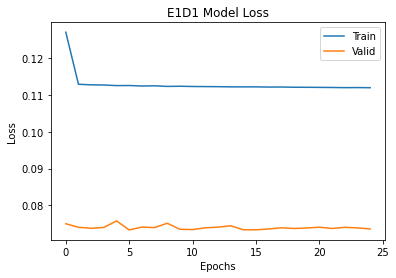

<IPython.core.display.Javascript object>

In [13]:
plt.plot(history_e1d1.history["loss"])
plt.plot(history_e1d1.history["val_loss"])
plt.title("E1D1 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Valid"])
plt.show()

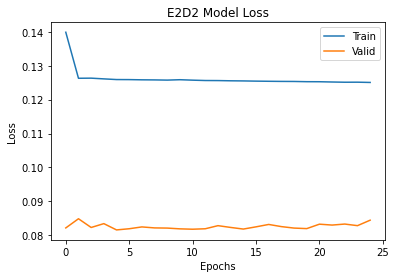

<IPython.core.display.Javascript object>

In [14]:
plt.plot(history_e2d2.history["loss"])
plt.plot(history_e2d2.history["val_loss"])
plt.title("E2D2 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Valid"])
plt.show()

In [15]:
# Prediction on test samples

pred1_e1d1 = model_e1d1.predict(X_test)
pred1_e2d2 = model_e2d2.predict(X_test)

pred_e1d1 = model_e1d1.predict(X_train)
pred_e2d2 = model_e2d2.predict(X_train)

<IPython.core.display.Javascript object>

### Inverse Scaling of the predicted values
Now we will convert the predictions to their original scale.

In [16]:
for index, i in enumerate(train_df.columns):
    scaler = scalers["scaler_" + i]
    pred1_e1d1[:, :, index] = scaler.inverse_transform(pred1_e1d1[:, :, index])
    pred_e1d1[:, :, index] = scaler.inverse_transform(pred_e1d1[:, :, index])

    pred1_e2d2[:, :, index] = scaler.inverse_transform(pred1_e2d2[:, :, index])
    pred_e2d2[:, :, index] = scaler.inverse_transform(pred_e2d2[:, :, index])

    y_train[:, :, index] = scaler.inverse_transform(y_train[:, :, index])
    y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])

<IPython.core.display.Javascript object>

### Checking Error

Now we will calculate the mean absolute error of all observations.

In [17]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()


High
Day  1 :
MAE-E1D1 :  10.812549686431884, MAE-E2D2 :  18.526346111297606
Day  2 :
MAE-E1D1 :  15.506125831604004, MAE-E2D2 :  22.050457000732422
Day  3 :
MAE-E1D1 :  18.21365327835083, MAE-E2D2 :  24.73927183151245
Day  4 :
MAE-E1D1 :  20.920842456817628, MAE-E2D2 :  28.62468547821045
Day  5 :
MAE-E1D1 :  23.330090522766113, MAE-E2D2 :  32.8567702293396


Low
Day  1 :
MAE-E1D1 :  11.437952899932862, MAE-E2D2 :  22.020809650421143
Day  2 :
MAE-E1D1 :  16.095239448547364, MAE-E2D2 :  26.660734462738038
Day  3 :
MAE-E1D1 :  18.627379608154296, MAE-E2D2 :  30.124668979644774
Day  4 :
MAE-E1D1 :  21.28769931793213, MAE-E2D2 :  34.13946905136108
Day  5 :
MAE-E1D1 :  23.697657203674318, MAE-E2D2 :  38.40768413543701


Open
Day  1 :
MAE-E1D1 :  7.031153774261474, MAE-E2D2 :  18.75428714752197
Day  2 :
MAE-E1D1 :  13.583072757720947, MAE-E2D2 :  22.63086862564087
Day  3 :
MAE-E1D1 :  16.883327102661134, MAE-E2D2 :  26.00587224960327
Day  4 :
MAE-E1D1 :  19.82519426345825, MAE-E2D2 :  29.838

<IPython.core.display.Javascript object>

y_test &  pred1_e1d1 plot

In [18]:
y_test[:, 0, 1].shape

(1280,)

<IPython.core.display.Javascript object>

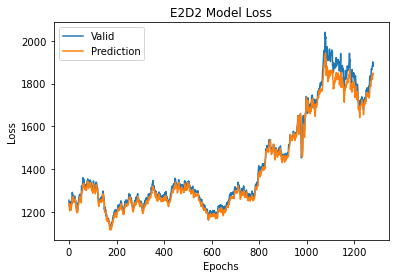

<IPython.core.display.Javascript object>

In [19]:
plt.plot(y_test[:, 0, 1])
plt.plot(pred1_e2d2[:, 0, 1])
plt.title("E2D2 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Valid", "Prediction"])
plt.show()